# Matlab data loading and processing

In [2]:
import numpy as np
import scipy.io
from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from preprocessing import *
from persistent_bow import *
from visualization import *

In [3]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [4]:
data.shape # Here are 50 diagrams (rows), 7 types(cols) = 350 diagrams

(50, 7)

In [5]:
data[0][1].shape # each diagram has n rows and 2 colums # here we get first diagram from type "1"

(23, 2)

In [6]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

# Different classes codebooks visualization

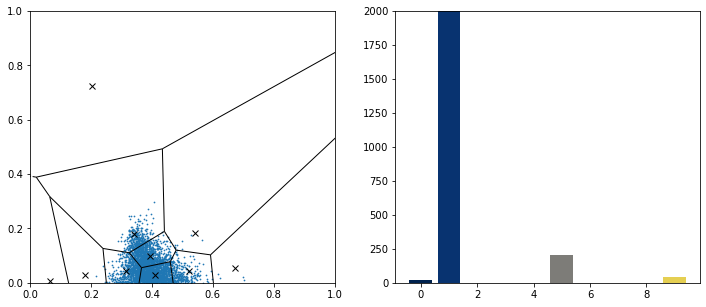

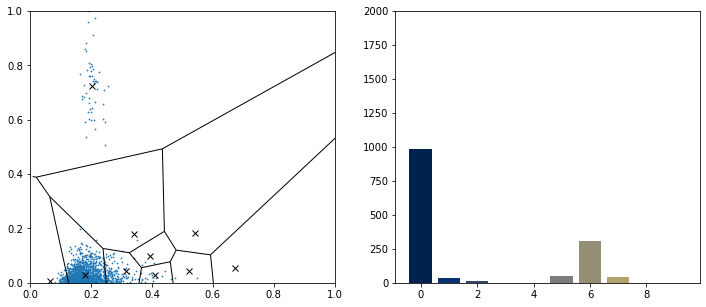

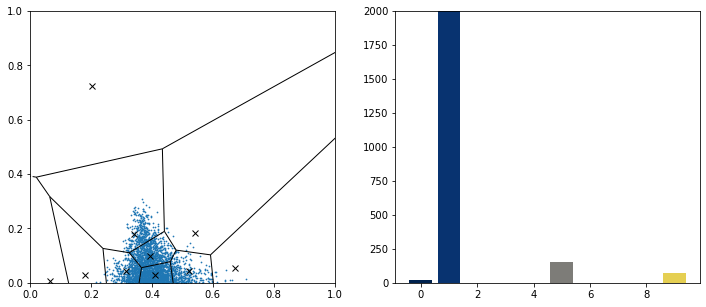

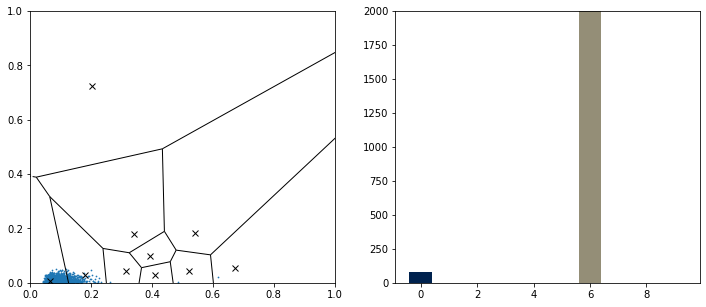

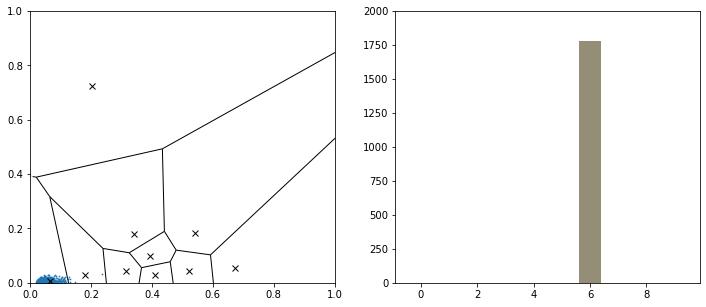

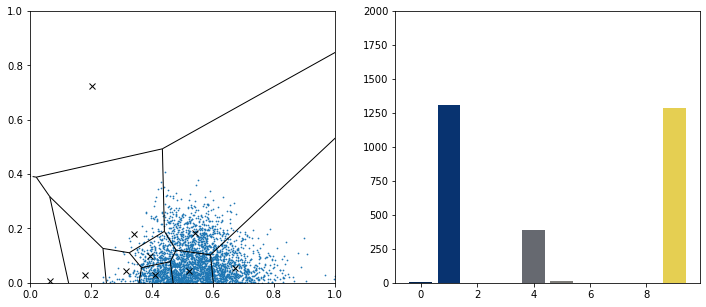

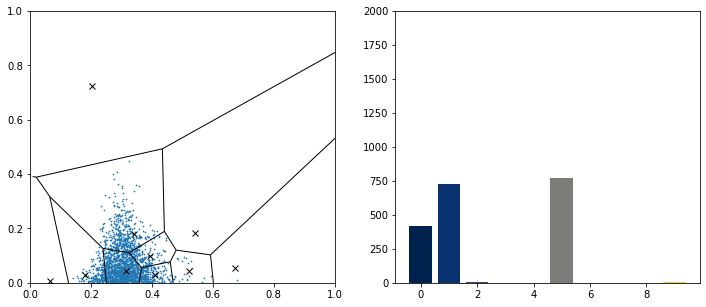

In [10]:
vectorizer = PersistentBow(KMeans(10))
vectorizer.fit(preprocessed)

for label in np.unique(y):    
    class_X = preprocessed[y==label]
    joined_X = np.concatenate(class_X)
    bow = vectorizer.transform([joined_X])[0]
    
    plt.figure(figsize=(12,5))
    ax = plt.subplot(121)
    plot_voronoi(vectorizer.cluster, ax=ax)
    ax.scatter(joined_X[:, 0], joined_X[:, 1], s=0.5)
    ax = plt.subplot(122)
    plot_bow(bow, 2000, ax=ax)

# Visualization of different weighting functions for sampler

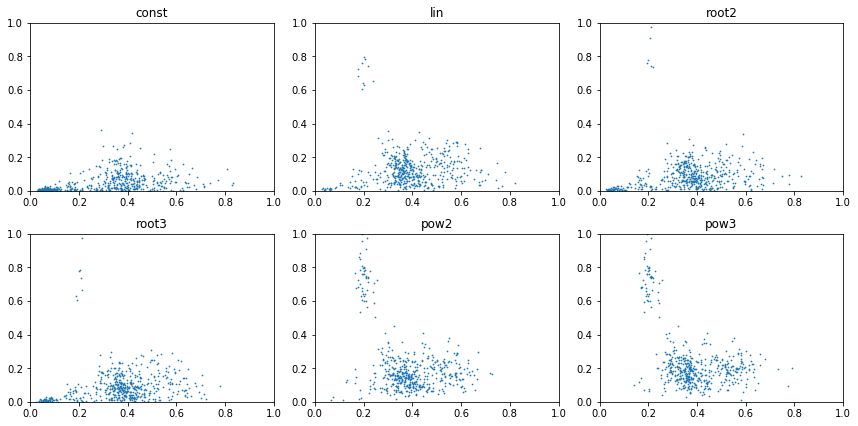

In [11]:
#Different persistence weighting functions visualization
sampling_weights = {
    "const":None,
    "lin" : lambda x : x,
    "root2" : lambda x : x**(1/2),
    "root3" : lambda x : x**(1/2),
    "pow2" : lambda x : x**2,
    "pow3" : lambda x : x**3,
}

index = 1
plt.figure(figsize=(12,6))

for name, weight in sampling_weights.items():
    transformed = RandomPDSampler(500, weight).fit_transform(preprocessed, y)[0]
    
    ax = plt.subplot(2,3,index)
    ax.set_title(name)
    ax.scatter(transformed[:, 0], transformed[:, 1], s=0.5)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    
    index += 1
    
plt.tight_layout(pad=1.0)

# Model comparison
## First step: Model hyperparameter optimization

In [20]:
import sklearn
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from gudhi.representations.kernel_methods import SlicedWassersteinKernel
from gudhi.representations.vector_methods import PersistenceImage
from gudhi.representations.metrics import BottleneckDistance
from cyvlfeat.kmeans import kmeans as Vlkmeans

#Fast hack to make SlicedWassersteinKernel scikit-compliant
setattr(SlicedWassersteinKernel, "get_params",
        lambda self, deep: {
            "bandwidth":self.bandwidth,
            "num_directions" : self.sw_.num_directions
        })


In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
fold = StratifiedKFold(5, shuffle=True)

In [14]:
#Helper function, constructs final pipeline and returns girdsearch for it
def make_final_grid(estimator, param_grid, *args, **kwargs ):
    new_param_grid = {f"Model__{name}" : values for name, values in param_grid.items()}
    final_pipeline = Pipeline([
        ("Model", estimator),
        ("Predictor", SVC(kernel = "linear"))
    ])
        
    return GridSearchCV(final_pipeline, new_param_grid, cv = fold, *args, **kwargs)

In [23]:
#PBoW gridsearch
pbow_pipeline = Pipeline([
    ("pbow",  PersistentBow(KMeans(7), sampler=RandomPDSampler(2500)))
])



pbow_gridsearch = make_final_grid(
    estimator = pbow_pipeline,
    param_grid = {
        "pbow__cluster__n_clusters" : np.arange(10, 200, 10),
        "pbow__sampler__max_points" : np.arange(1000, 13000, 1000),
        "pbow__sampler__weight_function" : [None, lambda x : x, lambda x : x**2]
    },
    n_jobs = -1
)

# PBOW with KMeans from VLFeat # TODO: This is Vl kmeans are 2 functions only
# We need to wrap it with something what fits fit, transform API
# pbow_on_stereoids = pbow_pipeline = Pipeline([
#     ("pbow",  PersistentBow(Vlkmeans(7,2), sampler=RandomPDSampler(2500)))
# ])



#SlicedWassersteinKernel gridsearch
swk_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    n_jobs = -1    
)

#BottleneckDistance gridsearch
bd_gridsearch = make_final_grid(
    estimator = BottleneckDistance(),
    param_grid = {
        "epsilon" : [None, 1e-8]
    },
    n_jobs = -1  
)

#PersistenceImage gridsearch
pi_gridsearch = make_final_grid(
    estimator = PersistenceImage(),
    param_grid = {
        "bandwidth" : [0.25, 0.5, 1, 1.5],
        #"weight" : [lambda x : 1, lambda x : x[1], lambda x : x[1]**2], #x=(birth, persistence)
        "resolution" : [(10,10), (20,20), (40,40)]
    },
    n_jobs = -1
)

models_to_test = {
    "PBoW" : pbow_gridsearch, 
    "SWK" : swk_gridsearch, 
    "Bottleneck" : bd_gridsearch,
    "PersistenceImage" : pi_gridsearch
}

In [17]:
import os
import dill #Temporary used for grid persistence
for name, grid in models_to_test.items():
    print(name)
    if os.path.exists(f"precomputed/{name}.grid.dill"):
        print("Loading from file")
        with open(f"precomputed/{name}.grid.dill", "br") as f:
            models_to_test[name] = dill.load(f)
    else:
        grid.verbose = 10
        grid.fit(X, y)
        with open(f"precomputed/{name}.grid.dill", "bw") as f:
            dill.dump(grid, f)

PBoW
Loading from file
SWK
Loading from file
Bottleneck
Loading from file
PersistenceImage
Loading from file


## Comparison of best estimators

In [16]:
results_dict = {}
for name, grid in models_to_test.items():
    print(name)
    model = grid.best_estimator_
    results = cross_validate(model, X, y, cv=5)
    results_dict[name] = results

PBoW
SWK
Bottleneck
PersistenceImage


In [20]:
for name, results in results_dict.items():
    print(name, "Mean scores:")
    df = pd.DataFrame(results)
    print(df.mean())

PBoW Mean scores:
fit_time      3.609549
score_time    0.046370
test_score    0.960000
dtype: float64
SWK Mean scores:
fit_time      4.182061
score_time    2.068396
test_score    0.977143
dtype: float64
Bottleneck Mean scores:
fit_time      86.951423
score_time    44.803060
test_score     0.742857
dtype: float64
PersistenceImage Mean scores:
fit_time      1.067000
score_time    0.262840
test_score    0.965714
dtype: float64


## Listing  of best parameters for each model

In [21]:
for name, grid in models_to_test.items():
    print(name, "Best parameters:")
    grid_params = grid.param_grid.keys()
    model = grid.best_estimator_
    for param_name in grid_params:
        param = model.get_params()[param_name]
        print(f'{param_name} :', param)
    print()

PBoW Best parameters:
Model__pbow__cluster__n_clusters : 40
Model__pbow__sampler__max_points : 11000
Model__pbow__sampler__weight_function : None

SWK Best parameters:
Model__bandwidth : 0.05
Model__num_directions : 10

Bottleneck Best parameters:
Model__epsilon : None

PersistenceImage Best parameters:
Model__bandwidth : 0.1
Model__weight : <function <lambda> at 0x000002043336C318>
Model__resolution : (40, 40)



## Plot - PBoW accuracy vs n_clusters

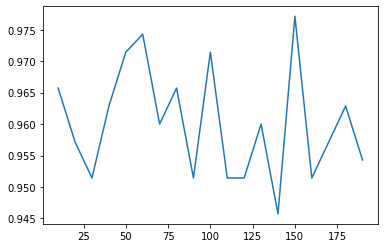

In [23]:
best_max_points = models_to_test["PBoW"].best_params_["Model__pbow__sampler__max_points"]
best_n_clusters = models_to_test["PBoW"].best_params_["Model__pbow__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__pbow__sampler__weight_function"]

result_list = []
n_clusters_range = np.arange(10, 200, 10)

for n_clusters in n_clusters_range:
    pbow_pipeline = Pipeline([
        ("bp_transform", BirthPersistenceTransform()),
        ("scaler", DiagramScaler(
            use=True,
            scalers=[
                ((0,), MaxAbsScaler(copy=False)),
                ((1,), MaxAbsScaler(copy=False))
            ]
        )),
        ("pbow",  PersistentBow(KMeans(n_clusters), RandomPDSampler(best_max_points, best_weight)))
    ])
    final_pipeline = Pipeline([
        ("Model", pbow_pipeline),
        ("Predictor", SVC(kernel="linear"))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=5)
    result_list.append(np.mean(results))
    
plt.plot(n_clusters_range, result_list)

## Plot - PBoW accuracy vs sampler max_points

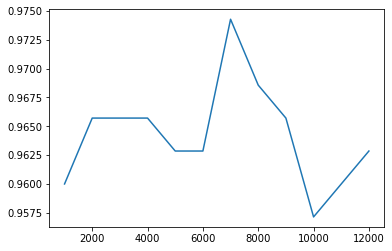

In [28]:
best_max_points = models_to_test["PBoW"].best_params_["Model__pbow__sampler__max_points"]
best_n_clusters = models_to_test["PBoW"].best_params_["Model__pbow__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__pbow__sampler__weight_function"]

result_list = []
max_points_range = np.arange(1000, 13000, 1000)

for max_points in max_points_range:
    pbow_pipeline = Pipeline([
        ("bp_transform", BirthPersistenceTransform()),
        ("scaler", DiagramScaler(
            use=True,
            scalers=[
                ((0,), MaxAbsScaler(copy=False)),
                ((1,), MaxAbsScaler(copy=False))
            ]
        )),
        ("pbow",  PersistentBow(KMeans(best_n_clusters), RandomPDSampler(max_points, best_weight)))
    ])
    final_pipeline = Pipeline([
        ("Model", pbow_pipeline),
        ("Predictor", SVC(kernel="linear"))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=5)
    result_list.append(np.mean(results))
    
plt.plot(max_points_range, result_list)